In [3]:
import pandas as pds
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline, interp1d
from scipy.linalg import svd

In [4]:
import pickle
from os import listdir
from os.path import isfile, join
import torch
mypath = '/Users/gcohn/Documents/D-CODE-ICLR-2022/gabe_train/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = [f for f in onlyfiles if "h_" in f]
onlyfiles = [f for f in onlyfiles if "medium" in f]
onlyfiles = [f for f in onlyfiles if int(f.split("_")[1].split(".")[0]) < 20]
y_total = []
for f in onlyfiles:
    print(f)
    with open(f'/Users/gcohn/Documents/D-CODE-ICLR-2022/gabe_train/{f}', 'rb') as file:
        y_partial = pickle.load(file)
        y_total.append(y_partial)
y_total = np.concatenate(y_total, axis=1)
print(y_total.shape)


h_10_train_medium.pkl
h_0_train_medium.pkl
h_4_train_medium.pkl
h_14_train_medium.pkl
h_11_train_medium.pkl
h_1_train_medium.pkl
h_5_train_medium.pkl
h_15_train_medium.pkl
h_19_train_medium.pkl
h_2_train_medium.pkl
h_12_train_medium.pkl
h_9_train_medium.pkl
h_16_train_medium.pkl
h_6_train_medium.pkl
h_3_train_medium.pkl
h_18_train_medium.pkl
h_8_train_medium.pkl
h_13_train_medium.pkl
h_17_train_medium.pkl
h_7_train_medium.pkl
(57, 1000, 8)


In [13]:
def get_df(z):
    df = []
    for i in range(y_total.shape[1]):
        d = {}
        # We are interpolating results to all 337 hours of the 14 day trajectory (including initial state)
        for j in range(14*24+1):
            d[j] = np.nan
            # Datapoints are sampled every 6 hours
            if j%6 == 0:
                d[j] = y_total[j//6][i][z]
        df.append(d)
    df = pds.DataFrame(df)
    return df

In [14]:
def build(y_interp, ind, df):
    y_time = np.arange(y_interp.shape[1]) / 336

    y_time_list = [y_time] * y_interp.shape[0]

    y_time = np.stack(y_time_list, axis=0).T[:, :, None]

    y_interp = y_interp.T[:, :, None]

    y_total = np.concatenate([y_interp, y_time], axis=-1)

    mask = ~np.isnan(df).T
    return y_total, mask

In [17]:
def get_smoothed_df(z):
    
    df = get_df(z)
    interp_list = []
    for i in range(df.shape[0]):
        
        row = df.iloc[i]
        ind = np.where(~np.isnan(row))[0]
        val = row[~np.isnan(row)]
        cs = interp1d(ind, val, axis=0, kind="linear", fill_value="extrapolate")

        y_interp = cs(np.arange(df.shape[1]))
        interp_list.append(y_interp) 

    y_interp = np.stack(interp_list, axis=0)
    y_interp_normalized = y_interp
    
    y_c1 = y_interp_normalized
    plt.plot(y_interp_normalized[0].T)
    y_total_c1, mask_c1 = build(y_c1, 0, df)
    return y_total_c1

(337, 1000, 2)
(337, 1000, 8)


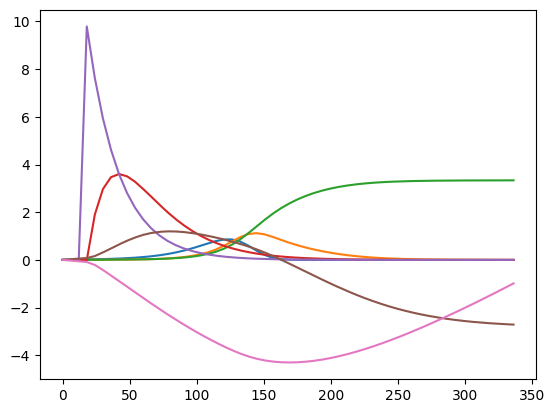

In [18]:
# df = get_df()
# ze variables
y_total_c0 = get_smoothed_df(0)
y_total_c1 = get_smoothed_df(1)
y_total_c2 = get_smoothed_df(2)
y_total_c3 = get_smoothed_df(3)

#dosage
y_total_c6 = get_smoothed_df(6)

# zm variables
y_total_c4 = get_smoothed_df(4)
y_total_c5 = get_smoothed_df(5)

print(y_total_c6.shape)

y_combo_ze = np.concatenate((
    y_total_c0[:,:,0:1], #x0
    y_total_c1[:,:,0:1], #x1
    y_total_c2[:,:,0:1], #x2
    y_total_c3[:,:,0:1], #x3
    y_total_c6[:,:,0:1], #x4
    y_total_c4[:,:,0:1], #x5
    y_total_c5) #x6, x7
    ,axis=-1)
print(y_combo_ze.shape)

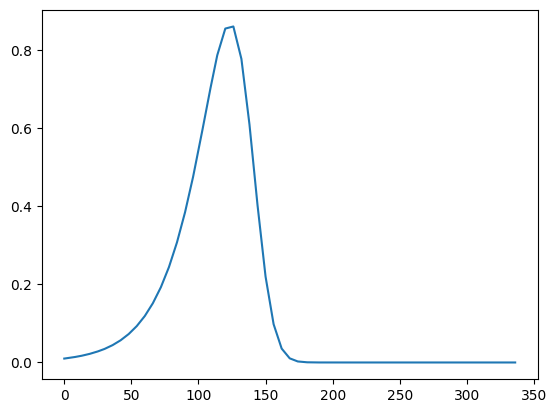

In [26]:
plt.plot(y_combo_ze[:,0,0])

In [39]:
with open("data/real_data_z_total_gabe_trained_train_dense.pkl", "wb") as f:
    pickle.dump(y_combo_ze, f)
